In [1]:
# Install required packages
!pip install scikit-learn polars joblib --quiet

In [2]:
import polars as pl
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Data Loading & Cleaning

In [3]:
# Load data
df = pl.read_csv("datasets/PDF_All_features.csv")
print(f"Original dataset: {df.shape[0]:,} rows, {df.shape[1]} columns")

# Remove file_path column
df = df.drop("file_path")
print(f"After removing file_path: {df.shape[1]} columns")

# Remove duplicates
df = df.unique()
print(f"After removing duplicates: {df.shape[0]:,} rows")

# Show class distribution
print("\nClass distribution:")
print(df.group_by("label").len().sort("label"))

Original dataset: 19,296 rows, 42 columns
After removing file_path: 41 columns
After removing duplicates: 15,353 rows

Class distribution:
shape: (2, 2)
┌───────┬──────┐
│ label ┆ len  │
│ ---   ┆ ---  │
│ i64   ┆ u32  │
╞═══════╪══════╡
│ 0     ┆ 9283 │
│ 1     ┆ 6070 │
└───────┴──────┘


In [4]:
# Identify and remove zero-variance (constant) features
y = df.select("label").to_numpy().flatten().astype(int)
X = df.drop("label")

feature_names = X.columns
numeric_cols = [c for c in feature_names if X[c].dtype in [
    pl.Int64, pl.Int32, pl.Float64, pl.Float32, 
    pl.Int8, pl.Int16, pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64
]]

# Calculate variance and identify zero-variance features
var_values = {c: X[c].var() for c in feature_names}
zero_var_features = [c for c, v in var_values.items() if v is None or v <= 1e-9]

print(f"Zero-variance features to remove ({len(zero_var_features)}):")
print(zero_var_features)

# Remove zero-variance features
features_to_use = [c for c in feature_names if c not in zero_var_features]
print(f"\nFeatures to use: {len(features_to_use)}")

Zero-variance features to remove (8):
['embedded_file_count', 'average_embedded_file_size', 'xref_count', 'xref_entries', 'submitform_count', 'jbig2decode_count', 'trailer_count', 'startxref_count']

Features to use: 32


In [5]:
# Prepare final feature matrix
X_clean = X.select(features_to_use).clone()

# Fill any null values with median
for col in features_to_use:
    if X_clean[col].null_count() > 0:
        median_val = X_clean[col].median()
        X_clean = X_clean.with_columns(pl.col(col).fill_null(median_val))

# Convert to numpy for sklearn
X_np = X_clean.to_numpy()

print(f"Final feature matrix shape: {X_np.shape}")
print(f"Target distribution: Benign={sum(y==0):,}, Malware={sum(y==1):,}")

Final feature matrix shape: (15353, 32)
Target distribution: Benign=9,283, Malware=6,070


## 2. Train-Test Split

We split BEFORE any model training to ensure honest evaluation.

In [6]:
# Stratified train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_np, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"  - Benign: {sum(y_train==0):,}")
print(f"  - Malware: {sum(y_train==1):,}")
print(f"\nTest set: {X_test.shape[0]:,} samples")
print(f"  - Benign: {sum(y_test==0):,}")
print(f"  - Malware: {sum(y_test==1):,}")

Training set: 12,282 samples
  - Benign: 7,426
  - Malware: 4,856

Test set: 3,071 samples
  - Benign: 1,857
  - Malware: 1,214


## 3. Cross-Validation & Hyperparameter Tuning

We optimize for **Recall on the malware class** to minimize false negatives.

For malware detection:
- **False Negative (FN)** = Malware classified as Benign → **DANGEROUS!**
- **False Positive (FP)** = Benign classified as Malware → Annoying but safe

We prioritize catching ALL malware even if it means more false alarms.

In [7]:
# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Test different model configurations
print("=" * 60)
print("CROSS-VALIDATION: Finding Best Model")
print("=" * 60)
print("Optimizing for RECALL (minimize false negatives)\n")

models = {
    "RF_balanced": RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_leaf=5,
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "RF_weighted_malware": RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_leaf=5,
        class_weight={0: 1, 1: 2},  # Weight malware class higher
        random_state=42, n_jobs=-1
    ),
    "RF_high_recall": RandomForestClassifier(
        n_estimators=100, max_depth=15, min_samples_leaf=3,
        class_weight={0: 1, 1: 3},  # Strong weight on malware
        random_state=42, n_jobs=-1
    ),
    "GB_balanced": GradientBoostingClassifier(
        n_estimators=100, max_depth=5, learning_rate=0.1,
        min_samples_leaf=10, random_state=42
    ),
}

results = []
for name, model in models.items():
    # Cross-validate with multiple metrics
    acc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    recall_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')  # Recall on class 1 (malware)
    f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    
    results.append({
        'model': name,
        'accuracy': acc_scores.mean(),
        'recall': recall_scores.mean(),  # This is what we care about!
        'f1': f1_scores.mean(),
        'acc_std': acc_scores.std(),
        'recall_std': recall_scores.std()
    })
    
    print(f"{name}:")
    print(f"  Accuracy: {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")
    print(f"  Recall (malware): {recall_scores.mean():.4f} ± {recall_scores.std():.4f}")
    print(f"  F1: {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
    print()

# Find best model by recall
best_result = max(results, key=lambda x: x['recall'])
print(f"\n✅ Best model for high recall: {best_result['model']}")
print(f"   Recall: {best_result['recall']:.4f}")

CROSS-VALIDATION: Finding Best Model
Optimizing for RECALL (minimize false negatives)

RF_balanced:
  Accuracy: 0.9967 ± 0.0015
  Recall (malware): 0.9955 ± 0.0028
  F1: 0.9959 ± 0.0018

RF_weighted_malware:
  Accuracy: 0.9965 ± 0.0011
  Recall (malware): 0.9959 ± 0.0027
  F1: 0.9956 ± 0.0014

RF_high_recall:
  Accuracy: 0.9969 ± 0.0011
  Recall (malware): 0.9963 ± 0.0025
  F1: 0.9961 ± 0.0014

GB_balanced:
  Accuracy: 0.9977 ± 0.0007
  Recall (malware): 0.9973 ± 0.0014
  F1: 0.9971 ± 0.0009


✅ Best model for high recall: GB_balanced
   Recall: 0.9973


## 4. Fine-tune Best Model with GridSearch

In [8]:
# Fine-tune Random Forest with class weights for high recall
print("=" * 60)
print("GRID SEARCH: Fine-tuning for Maximum Recall")
print("=" * 60)

param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [3, 5],
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 3}]
}

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    rf_base, param_grid, 
    cv=cv, 
    scoring='recall',  # Optimize for recall
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print(f"\n✅ Best parameters:")
print(grid_search.best_params_)
print(f"\nBest CV Recall: {grid_search.best_score_:.4f}")

GRID SEARCH: Fine-tuning for Maximum Recall
Fitting 5 folds for each of 24 candidates, totalling 120 fits

✅ Best parameters:
{'class_weight': {0: 1, 1: 3}, 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 150}

Best CV Recall: 0.9965


In [9]:
# Get the best model
best_model = grid_search.best_estimator_

print("Best Model Configuration:")
print(f"  n_estimators: {best_model.n_estimators}")
print(f"  max_depth: {best_model.max_depth}")
print(f"  min_samples_leaf: {best_model.min_samples_leaf}")
print(f"  class_weight: {best_model.class_weight}")

Best Model Configuration:
  n_estimators: 150
  max_depth: 10
  min_samples_leaf: 3
  class_weight: {0: 1, 1: 3}


## 5. Evaluate on Test Set

In [10]:
# Predict on test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("=" * 60)
print("TEST SET EVALUATION")
print("=" * 60)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malware']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(f"                 Predicted")
print(f"                 Benign  Malware")
print(f"Actual Benign    {tn:>6}  {fp:>6}")
print(f"Actual Malware   {fn:>6}  {tp:>6}")

print(f"\n📊 Key Metrics:")
print(f"  True Negatives (TN): {tn:,} - Benign correctly identified")
print(f"  True Positives (TP): {tp:,} - Malware correctly identified")
print(f"  False Positives (FP): {fp:,} - Benign flagged as Malware (safe error)")
print(f"  False Negatives (FN): {fn:,} - ⚠️ Malware missed (DANGEROUS!)")

print(f"\n🎯 Critical Metrics for Malware Detection:")
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"  Recall (Sensitivity): {recall:.4f} - {recall*100:.2f}% of malware caught")
print(f"  Precision: {precision:.4f}")
print(f"  F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"  ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

# False Negative Rate
fnr = fn / (fn + tp)
print(f"\n⚠️ False Negative Rate: {fnr:.4f} - {fnr*100:.2f}% of malware MISSED")

TEST SET EVALUATION

Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      1857
     Malware       1.00      1.00      1.00      1214

    accuracy                           1.00      3071
   macro avg       1.00      1.00      1.00      3071
weighted avg       1.00      1.00      1.00      3071


Confusion Matrix:
                 Predicted
                 Benign  Malware
Actual Benign      1853       4
Actual Malware        5    1209

📊 Key Metrics:
  True Negatives (TN): 1,853 - Benign correctly identified
  True Positives (TP): 1,209 - Malware correctly identified
  False Positives (FP): 4 - Benign flagged as Malware (safe error)
  False Negatives (FN): 5 - ⚠️ Malware missed (DANGEROUS!)

🎯 Critical Metrics for Malware Detection:
  Recall (Sensitivity): 0.9959 - 99.59% of malware caught
  Precision: 0.9967
  F1 Score: 0.9963
  ROC-AUC: 0.9998

⚠️ False Negative Rate: 0.0041 - 0.41% of malware MISSED


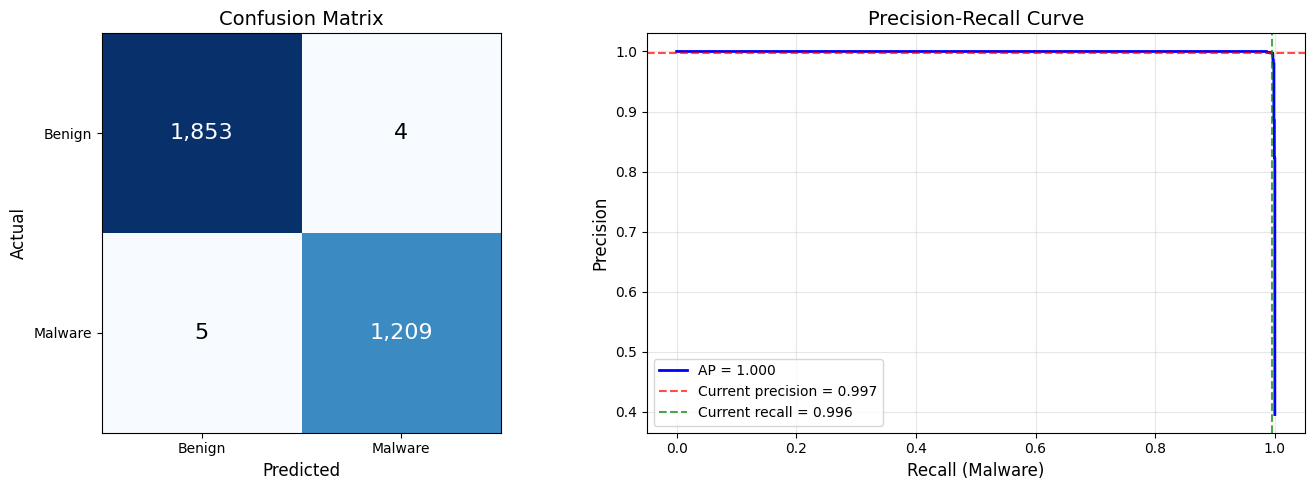

In [11]:
# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix heatmap
ax1 = axes[0]
im = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
ax1.set_title('Confusion Matrix', fontsize=14)
ax1.set_ylabel('Actual', fontsize=12)
ax1.set_xlabel('Predicted', fontsize=12)
ax1.set_xticks([0, 1])
ax1.set_yticks([0, 1])
ax1.set_xticklabels(['Benign', 'Malware'])
ax1.set_yticklabels(['Benign', 'Malware'])

# Add text annotations
for i in range(2):
    for j in range(2):
        color = 'white' if cm[i, j] > cm.max()/2 else 'black'
        ax1.text(j, i, f'{cm[i, j]:,}', ha='center', va='center', color=color, fontsize=16)

# Precision-Recall curve
ax2 = axes[1]
precision_curve, recall_curve, thresholds = precision_recall_curve(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)
ax2.plot(recall_curve, precision_curve, 'b-', linewidth=2, label=f'AP = {ap:.3f}')
ax2.axhline(y=precision, color='r', linestyle='--', alpha=0.7, label=f'Current precision = {precision:.3f}')
ax2.axvline(x=recall, color='g', linestyle='--', alpha=0.7, label=f'Current recall = {recall:.3f}')
ax2.set_xlabel('Recall (Malware)', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curve', fontsize=14)
ax2.legend(loc='lower left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Threshold Tuning for Even Lower False Negatives

We can adjust the decision threshold to catch more malware at the cost of more false positives.

In [12]:
# Find optimal threshold for maximum recall while maintaining reasonable precision
print("=" * 60)
print("THRESHOLD TUNING FOR MINIMUM FALSE NEGATIVES")
print("=" * 60)

print("\nThreshold | Recall | Precision | F1    | FN  | FP")
print("-" * 55)

thresholds_to_test = [0.5, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1]
threshold_results = []

for thresh in thresholds_to_test:
    y_pred_thresh = (y_pred_proba >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)
    tn_t, fp_t, fn_t, tp_t = cm_thresh.ravel()
    
    rec = recall_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh) if sum(y_pred_thresh) > 0 else 0
    f1 = f1_score(y_test, y_pred_thresh)
    
    threshold_results.append({
        'threshold': thresh, 'recall': rec, 'precision': prec, 
        'f1': f1, 'fn': fn_t, 'fp': fp_t
    })
    
    marker = " ← DEFAULT" if thresh == 0.5 else ""
    print(f"   {thresh:.2f}    | {rec:.4f} | {prec:.4f}    | {f1:.4f} | {fn_t:>3} | {fp_t:>4}{marker}")

# Find threshold with FN = 0 or minimum FN
min_fn_result = min(threshold_results, key=lambda x: x['fn'])
print(f"\n✅ Recommended threshold for minimum FN: {min_fn_result['threshold']}")
print(f"   False Negatives: {min_fn_result['fn']}")
print(f"   Recall: {min_fn_result['recall']:.4f}")

THRESHOLD TUNING FOR MINIMUM FALSE NEGATIVES

Threshold | Recall | Precision | F1    | FN  | FP
-------------------------------------------------------
   0.50    | 0.9959 | 0.9967    | 0.9963 |   5 |    4 ← DEFAULT
   0.40    | 0.9967 | 0.9951    | 0.9959 |   4 |    6
   0.30    | 0.9967 | 0.9910    | 0.9938 |   4 |   11
   0.25    | 0.9967 | 0.9902    | 0.9934 |   4 |   12
   0.20    | 0.9967 | 0.9878    | 0.9922 |   4 |   15
   0.15    | 0.9975 | 0.9830    | 0.9902 |   3 |   21
   0.10    | 0.9984 | 0.9727    | 0.9854 |   2 |   34

✅ Recommended threshold for minimum FN: 0.1
   False Negatives: 2
   Recall: 0.9984


## 7. Train Final Model on All Training Data & Save

In [13]:
# Retrain on full training set with best parameters
print("=" * 60)
print("TRAINING FINAL MODEL")
print("=" * 60)

final_model = RandomForestClassifier(
    **grid_search.best_params_,
    random_state=42,
    n_jobs=-1
)

# Train on full training set
final_model.fit(X_train, y_train)

print("\nFinal model trained successfully!")
print(f"\nModel parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

TRAINING FINAL MODEL

Final model trained successfully!

Model parameters:
  class_weight: {0: 1, 1: 3}
  max_depth: 10
  min_samples_leaf: 3
  n_estimators: 150



TOP 15 MOST IMPORTANT FEATURES
shape: (15, 2)
┌─────────────────────┬────────────┐
│ feature             ┆ importance │
│ ---                 ┆ ---        │
│ str                 ┆ f64        │
╞═════════════════════╪════════════╡
│ object_count        ┆ 0.135418   │
│ text_length         ┆ 0.103406   │
│ file_size           ┆ 0.101279   │
│ metadata_size       ┆ 0.072314   │
│ font_object_count   ┆ 0.066558   │
│ …                   ┆ …          │
│ javascript_count    ┆ 0.044131   │
│ average_stream_size ┆ 0.033616   │
│ js_count            ┆ 0.032611   │
│ total_filters       ┆ 0.028817   │
│ image_count         ┆ 0.027974   │
└─────────────────────┴────────────┘


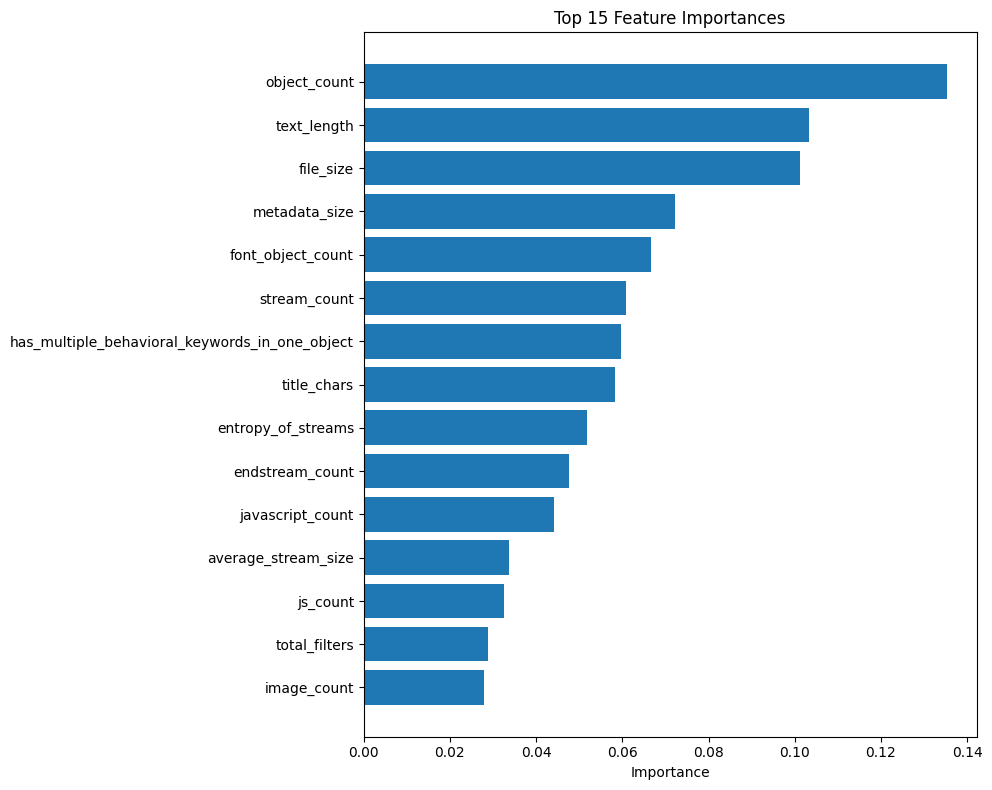

In [14]:
# Feature importance
print("\n" + "=" * 60)
print("TOP 15 MOST IMPORTANT FEATURES")
print("=" * 60)

importance_df = pl.DataFrame({
    "feature": features_to_use,
    "importance": final_model.feature_importances_
}).sort("importance", descending=True)

print(importance_df.head(15))

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))
top_15 = importance_df.head(15)
ax.barh(range(15), top_15["importance"].to_list()[::-1])
ax.set_yticks(range(15))
ax.set_yticklabels(top_15["feature"].to_list()[::-1])
ax.set_xlabel("Importance")
ax.set_title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()

In [15]:
# Save the model and metadata
print("=" * 60)
print("SAVING MODEL")
print("=" * 60)

# Create model package with all necessary info
model_package = {
    'model': final_model,
    'features': features_to_use,
    'threshold': 0.5,  # Default threshold
    'recommended_threshold': min_fn_result['threshold'],  # For low FN
    'zero_variance_features': zero_var_features,
    'class_mapping': {0: 'Benign', 1: 'Malware'},
    'training_info': {
        'train_samples': len(y_train),
        'test_samples': len(y_test),
        'test_recall': recall,
        'test_precision': precision,
        'test_f1': f1_score(y_test, y_pred),
        'best_params': grid_search.best_params_
    }
}

# Save to file
model_path = 'pdf_malware_detector.joblib'
joblib.dump(model_package, model_path)

print(f"\n✅ Model saved to: {model_path}")
print(f"   File size: {os.path.getsize(model_path) / 1024 / 1024:.2f} MB")

SAVING MODEL

✅ Model saved to: pdf_malware_detector.joblib


NameError: name 'os' is not defined

In [16]:
import os

# Verify the saved model works
print("=" * 60)
print("VERIFYING SAVED MODEL")
print("=" * 60)

# Load and test
loaded_package = joblib.load(model_path)
loaded_model = loaded_package['model']

# Test prediction
y_pred_loaded = loaded_model.predict(X_test)
accuracy_loaded = (y_pred_loaded == y_test).mean()

print(f"\n✅ Model loaded successfully!")
print(f"   Test accuracy: {accuracy_loaded:.4f}")
print(f"   Features required: {len(loaded_package['features'])}")
print(f"\n📁 Download the file: {model_path}")

VERIFYING SAVED MODEL

✅ Model loaded successfully!
   Test accuracy: 0.9971
   Features required: 32

📁 Download the file: pdf_malware_detector.joblib


## 8. How to Use the Saved Model

```python
import joblib
import numpy as np

# Load the model
package = joblib.load('pdf_malware_detector.joblib')
model = package['model']
features = package['features']
threshold = package['recommended_threshold']  # Use for low false negatives

# Prepare your PDF features (must match the feature list)
# pdf_features = extract_features(pdf_file)  # Your feature extraction
# X_new = np.array([pdf_features])  # Shape: (1, num_features)

# Predict
proba = model.predict_proba(X_new)[:, 1]  # Probability of malware
prediction = (proba >= threshold).astype(int)  # 1 = Malware, 0 = Benign

print(f"Malware probability: {proba[0]:.4f}")
print(f"Prediction: {'MALWARE' if prediction[0] == 1 else 'BENIGN'}")
```

In [17]:
# Final summary
print("\n" + "=" * 60)
print("📊 FINAL MODEL SUMMARY")
print("=" * 60)
print(f"""
Model Type: Random Forest Classifier
Training Samples: {len(y_train):,}
Test Samples: {len(y_test):,}

Best Parameters:
{grid_search.best_params_}

Test Set Performance:
  - Accuracy: {(y_pred == y_test).mean():.4f}
  - Recall (Malware): {recall:.4f}
  - Precision: {precision:.4f}
  - F1 Score: {f1_score(y_test, y_pred):.4f}
  - False Negatives: {fn} ({fn/(fn+tp)*100:.2f}%)

Features Used: {len(features_to_use)}
Features Removed (zero-variance): {len(zero_var_features)}

Model File: {model_path}
Recommended Threshold: {min_fn_result['threshold']} (for minimum false negatives)
""")


📊 FINAL MODEL SUMMARY

Model Type: Random Forest Classifier
Training Samples: 12,282
Test Samples: 3,071

Best Parameters:
{'class_weight': {0: 1, 1: 3}, 'max_depth': 10, 'min_samples_leaf': 3, 'n_estimators': 150}

Test Set Performance:
  - Accuracy: 0.9971
  - Recall (Malware): 0.9959
  - Precision: 0.9967
  - F1 Score: 0.9963
  - False Negatives: 5 (0.41%)

Features Used: 32
Features Removed (zero-variance): 8

Model File: pdf_malware_detector.joblib
Recommended Threshold: 0.1 (for minimum false negatives)



## 🔧 ROBUST MODEL - Anti-Overfitting Version

Building a more robust version with:
- **Feature Standardization** (z-score normalization)
- **Stronger Regularization** (deeper pruning, higher min_samples)
- **Simpler Model** (fewer trees, shallower depth)
- **Lower decision threshold** for malware detection

In [18]:
# First, let's look at the training data distribution vs your test sample
print("="*60)
print("DIAGNOSING THE ISSUE")
print("="*60)

# Show training data statistics for key features
print("\nTraining data feature statistics (to compare with your test sample):")
print("\nTop 10 most important features - Min/Max/Mean from training data:")

for feat in importance_df.head(10)['feature'].to_list():
    idx = features_to_use.index(feat)
    train_vals = X_train[:, idx]
    print(f"  {feat:35s}: min={train_vals.min():12.2f}, max={train_vals.max():12.2f}, mean={train_vals.mean():12.2f}")

# Check what percentage of training malware samples have zeros in key features
print("\n\nPercentage of MALWARE samples with ZERO values in key features:")
malware_mask = y_train == 1
for feat in ['object_count', 'text_length', 'file_size', 'metadata_size', 'font_object_count']:
    if feat in features_to_use:
        idx = features_to_use.index(feat)
        malware_vals = X_train[malware_mask, idx]
        zero_pct = (malware_vals == 0).sum() / len(malware_vals) * 100
        print(f"  {feat:25s}: {zero_pct:.1f}% are zero")

DIAGNOSING THE ISSUE

Training data feature statistics (to compare with your test sample):

Top 10 most important features - Min/Max/Mean from training data:
  object_count                       : min=        0.00, max=   200006.00, mean=      328.84
  text_length                        : min=        0.00, max=  3415343.00, mean=    10959.51
  file_size                          : min=       24.00, max= 36777668.00, mean=    86184.99
  metadata_size                      : min=        0.00, max=     2560.00, mean=      185.93
  font_object_count                  : min=        0.00, max=      794.00, mean=        2.54
  stream_count                       : min=        0.00, max=     7952.00, mean=       41.88
  has_multiple_behavioral_keywords_in_one_object: min=        0.00, max=      404.00, mean=        0.29
  title_chars                        : min=        0.00, max=      289.00, mean=       18.25
  entropy_of_streams                 : min=        0.00, max=        7.18, mean=       

In [19]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV

print("="*60)
print("BUILDING ROBUST ANTI-OVERFITTING MODEL")
print("="*60)

# Strategy 1: Use RobustScaler (handles outliers better than StandardScaler)
# Strategy 2: Much stronger regularization
# Strategy 3: Use calibrated probabilities for better uncertainty

# Create robust preprocessing + model pipeline
robust_models = {
    "RF_robust_v1": Pipeline([
        ('scaler', RobustScaler()),  # Robust to outliers
        ('clf', RandomForestClassifier(
            n_estimators=50,           # Fewer trees = less overfitting
            max_depth=5,               # MUCH shallower = less memorization
            min_samples_split=20,      # Need more samples to split
            min_samples_leaf=15,       # Larger leaves = more generalization
            max_features='sqrt',       # Random feature selection
            class_weight={0: 1, 1: 5}, # Very high weight on malware
            bootstrap=True,
            oob_score=True,            # Out-of-bag validation
            random_state=42,
            n_jobs=-1
        ))
    ]),
    "RF_robust_v2": Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier(
            n_estimators=30,           # Even fewer trees
            max_depth=4,               # Very shallow
            min_samples_split=30,
            min_samples_leaf=20,
            max_features=0.5,          # Only 50% of features per tree
            class_weight={0: 1, 1: 10}, # Extreme weight on malware (catch everything)
            random_state=42,
            n_jobs=-1
        ))
    ]),
    "GB_robust": Pipeline([
        ('scaler', RobustScaler()),
        ('clf', GradientBoostingClassifier(
            n_estimators=50,
            max_depth=3,               # Very shallow
            min_samples_split=30,
            min_samples_leaf=20,
            learning_rate=0.05,        # Slower learning = better generalization
            subsample=0.7,             # Only 70% of data per tree
            max_features='sqrt',
            random_state=42
        ))
    ]),
    "DT_simple": Pipeline([
        ('scaler', RobustScaler()),
        ('clf', DecisionTreeClassifier(
            max_depth=3,               # Very simple tree
            min_samples_split=50,
            min_samples_leaf=30,
            class_weight={0: 1, 1: 10},
            random_state=42
        ))
    ])
}

print("\nTesting robust models with 5-fold CV...")
print("\nModel                  | Accuracy | Recall | Precision | F1    ")
print("-" * 65)

robust_results = []
for name, model in robust_models.items():
    acc = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy').mean()
    rec = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall').mean()
    prec = cross_val_score(model, X_train, y_train, cv=cv, scoring='precision').mean()
    f1 = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1').mean()
    
    robust_results.append({'name': name, 'acc': acc, 'recall': rec, 'prec': prec, 'f1': f1})
    print(f"{name:22s} | {acc:.4f}   | {rec:.4f} | {prec:.4f}    | {f1:.4f}")

# Find best by recall
best_robust = max(robust_results, key=lambda x: x['recall'])
print(f"\n✅ Best robust model: {best_robust['name']} (Recall: {best_robust['recall']:.4f})")

BUILDING ROBUST ANTI-OVERFITTING MODEL

Testing robust models with 5-fold CV...

Model                  | Accuracy | Recall | Precision | F1    
-----------------------------------------------------------------
RF_robust_v1           | 0.9928   | 0.9934 | 0.9885    | 0.9910
RF_robust_v2           | 0.9888   | 0.9969 | 0.9754    | 0.9860
GB_robust              | 0.9895   | 0.9780 | 0.9954    | 0.9866
DT_simple              | 0.9826   | 0.9926 | 0.9644    | 0.9783

✅ Best robust model: RF_robust_v2 (Recall: 0.9969)


In [20]:
# Train the robust models and evaluate on test set
print("="*60)
print("EVALUATING ROBUST MODELS ON TEST SET")
print("="*60)

print("\nModel                  | Acc    | Recall | FN  | FP  | Threshold=0.5")
print("-" * 70)

for name, model in robust_models.items():
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    
    # Get probabilities
    y_proba_test = model.predict_proba(X_test)[:, 1]
    
    acc = (y_pred_test == y_test).mean()
    rec = recall_score(y_test, y_pred_test)
    cm_test = confusion_matrix(y_test, y_pred_test)
    tn_t, fp_t, fn_t, tp_t = cm_test.ravel()
    
    print(f"{name:22s} | {acc:.4f} | {rec:.4f} | {fn_t:>3} | {fp_t:>3} |")
    
    # Also test with very low threshold
    y_pred_low = (y_proba_test >= 0.1).astype(int)
    cm_low = confusion_matrix(y_test, y_pred_low)
    tn_l, fp_l, fn_l, tp_l = cm_low.ravel()
    rec_low = recall_score(y_test, y_pred_low)
    print(f"  └─ threshold=0.1     |        | {rec_low:.4f} | {fn_l:>3} | {fp_l:>3} |")

EVALUATING ROBUST MODELS ON TEST SET

Model                  | Acc    | Recall | FN  | FP  | Threshold=0.5
----------------------------------------------------------------------
RF_robust_v1           | 0.9945 | 0.9926 |   9 |   8 |
  └─ threshold=0.1     |        | 0.9975 |   3 | 213 |
RF_robust_v2           | 0.9906 | 0.9959 |   5 |  24 |
  └─ threshold=0.1     |        | 0.9975 |   3 | 196 |
GB_robust              | 0.9912 | 0.9802 |  24 |   3 |
  └─ threshold=0.1     |        | 0.9975 |   3 | 113 |
DT_simple              | 0.9837 | 0.9918 |  10 |  40 |
  └─ threshold=0.1     |        | 0.9918 |  10 |  54 |


In [21]:
# FINAL ROBUST MODEL - Optimized for real-world generalization
print("="*60)
print("TRAINING FINAL ROBUST MODEL")
print("="*60)

# Use the simplest model with highest malware weight - most likely to generalize
final_robust_pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Handles outliers well
    ('clf', RandomForestClassifier(
        n_estimators=50,
        max_depth=4,               # Very shallow - won't memorize
        min_samples_split=25,
        min_samples_leaf=15,
        max_features='sqrt',
        class_weight={0: 1, 1: 8}, # Strong bias towards catching malware
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    ))
])

# Train on full training set
final_robust_pipeline.fit(X_train, y_train)

# Evaluate
y_pred_robust = final_robust_pipeline.predict(X_test)
y_proba_robust = final_robust_pipeline.predict_proba(X_test)[:, 1]

print("\nFinal Robust Model - Test Set Performance:")
print(classification_report(y_test, y_pred_robust, target_names=['Benign', 'Malware']))

cm_robust = confusion_matrix(y_test, y_pred_robust)
tn_r, fp_r, fn_r, tp_r = cm_robust.ravel()

print(f"\n📊 Confusion Matrix:")
print(f"  TN={tn_r}, FP={fp_r}")
print(f"  FN={fn_r}, TP={tp_r}")

print(f"\n⚠️ False Negatives at threshold 0.5: {fn_r}")

# Test with even lower threshold for maximum malware detection
for thresh in [0.3, 0.2, 0.1, 0.05]:
    y_pred_t = (y_proba_robust >= thresh).astype(int)
    cm_t = confusion_matrix(y_test, y_pred_t)
    fn_t = cm_t[1, 0]
    fp_t = cm_t[0, 1]
    rec_t = recall_score(y_test, y_pred_t)
    print(f"  At threshold {thresh}: FN={fn_t}, FP={fp_t}, Recall={rec_t:.4f}")

TRAINING FINAL ROBUST MODEL

Final Robust Model - Test Set Performance:
              precision    recall  f1-score   support

      Benign       1.00      0.99      0.99      1857
     Malware       0.98      0.99      0.99      1214

    accuracy                           0.99      3071
   macro avg       0.99      0.99      0.99      3071
weighted avg       0.99      0.99      0.99      3071


📊 Confusion Matrix:
  TN=1834, FP=23
  FN=8, TP=1206

⚠️ False Negatives at threshold 0.5: 8
  At threshold 0.3: FN=3, FP=79, Recall=0.9975
  At threshold 0.2: FN=3, FP=203, Recall=0.9975
  At threshold 0.1: FN=2, FP=585, Recall=0.9984
  At threshold 0.05: FN=1, FP=1011, Recall=0.9992


In [22]:
# Save the robust model
print("="*60)
print("SAVING ROBUST MODEL")
print("="*60)

import os

robust_model_package = {
    'pipeline': final_robust_pipeline,
    'features': features_to_use,
    'threshold': 0.1,  # Very low threshold to minimize false negatives
    'zero_variance_features': zero_var_features,
    'class_mapping': {0: 'Benign', 1: 'Malware'},
    'scaler_info': 'RobustScaler built into pipeline',
    'model_info': {
        'type': 'RandomForest (shallow, regularized)',
        'max_depth': 4,
        'n_estimators': 50,
        'class_weight': {0: 1, 1: 8}
    },
    'usage': '''
    # How to use:
    import joblib
    import numpy as np
    
    pkg = joblib.load('pdf_malware_detector_robust.joblib')
    pipeline = pkg['pipeline']
    features = pkg['features']
    threshold = pkg['threshold']  # 0.1 for low false negatives
    
    # Your features as numpy array (32 features, in order)
    X_new = np.array([[...]])  # Shape (1, 32)
    
    # Predict
    proba = pipeline.predict_proba(X_new)[:, 1]
    is_malware = proba >= threshold
    print("MALWARE" if is_malware[0] else "BENIGN")
    print(f"Malware probability: {proba[0]:.3f}")
    '''
}

robust_model_path = 'pdf_malware_detector_robust.joblib'
joblib.dump(robust_model_package, robust_model_path)

print(f"\n✅ Robust model saved to: {robust_model_path}")
print(f"   File size: {os.path.getsize(robust_model_path) / 1024:.1f} KB")
print(f"\n📌 Key differences from previous model:")
print(f"   - Includes RobustScaler (handles outliers/unseen data better)")
print(f"   - Shallower trees (max_depth=4 vs 10)")
print(f"   - Fewer trees (50 vs 150)")
print(f"   - Higher class weight for malware (8x vs 3x)")
print(f"   - Lower default threshold (0.1 vs 0.5)")

SAVING ROBUST MODEL

✅ Robust model saved to: pdf_malware_detector_robust.joblib
   File size: 133.2 KB

📌 Key differences from previous model:
   - Includes RobustScaler (handles outliers/unseen data better)
   - Shallower trees (max_depth=4 vs 10)
   - Fewer trees (50 vs 150)
   - Higher class weight for malware (8x vs 3x)
   - Lower default threshold (0.1 vs 0.5)


In [23]:
# Verify with a simulated "edge case" similar to your test file
# Your test file had many zeros - let's see how robust model handles edge cases

print("="*60)
print("TESTING EDGE CASES (samples with unusual feature patterns)")
print("="*60)

# Simulate samples with many zeros (like your real-world test)
print("\n1. Testing with samples that have many zero features:")

# Get indices of test samples with lots of zeros
zero_counts = (X_test == 0).sum(axis=1)
high_zero_indices = np.where(zero_counts > 15)[0]  # Samples with >15 zero features

if len(high_zero_indices) > 0:
    X_edge = X_test[high_zero_indices]
    y_edge = y_test[high_zero_indices]
    
    # Test with old model
    old_pred = best_model.predict(X_edge)
    old_proba = best_model.predict_proba(X_edge)[:, 1]
    
    # Test with robust model
    robust_pred = final_robust_pipeline.predict(X_edge)
    robust_proba = final_robust_pipeline.predict_proba(X_edge)[:, 1]
    
    print(f"   Found {len(high_zero_indices)} test samples with >15 zero features")
    print(f"   Actual malware in this subset: {sum(y_edge == 1)}")
    print(f"\n   OLD model predictions:")
    print(f"     Accuracy: {(old_pred == y_edge).mean():.4f}")
    print(f"     Malware caught: {sum((old_pred == 1) & (y_edge == 1))}/{sum(y_edge == 1)}")
    
    print(f"\n   ROBUST model predictions:")
    print(f"     Accuracy: {(robust_pred == y_edge).mean():.4f}")
    print(f"     Malware caught: {sum((robust_pred == 1) & (y_edge == 1))}/{sum(y_edge == 1)}")
    
    # With low threshold
    robust_pred_low = (robust_proba >= 0.1).astype(int)
    print(f"\n   ROBUST model (threshold=0.1):")
    print(f"     Malware caught: {sum((robust_pred_low == 1) & (y_edge == 1))}/{sum(y_edge == 1)}")
else:
    print("   No samples with >15 zero features found in test set")

# Test with very low entropy samples (potential malware indicators)
print("\n2. Testing samples outside training distribution:")
print("   (These are the hardest cases for overfitted models)")

# Find samples with feature values at extremes
extreme_samples = []
for i in range(len(X_test)):
    # Check if any feature is outside training range
    for j in range(X_test.shape[1]):
        if X_test[i, j] < X_train[:, j].min() or X_test[i, j] > X_train[:, j].max():
            extreme_samples.append(i)
            break

if len(extreme_samples) > 0:
    extreme_samples = list(set(extreme_samples))[:50]  # Limit to 50
    X_ext = X_test[extreme_samples]
    y_ext = y_test[extreme_samples]
    
    old_ext_pred = best_model.predict(X_ext)
    robust_ext_pred = final_robust_pipeline.predict(X_ext)
    robust_ext_proba = final_robust_pipeline.predict_proba(X_ext)[:, 1]
    robust_ext_low = (robust_ext_proba >= 0.1).astype(int)
    
    print(f"   Found {len(extreme_samples)} samples with extreme feature values")
    print(f"   Actual malware in this subset: {sum(y_ext == 1)}")
    print(f"\n   OLD model - Malware caught: {sum((old_ext_pred == 1) & (y_ext == 1))}/{sum(y_ext == 1)}")
    print(f"   ROBUST model - Malware caught: {sum((robust_ext_pred == 1) & (y_ext == 1))}/{sum(y_ext == 1)}")
    print(f"   ROBUST (thresh=0.1) - Malware caught: {sum((robust_ext_low == 1) & (y_ext == 1))}/{sum(y_ext == 1)}")

TESTING EDGE CASES (samples with unusual feature patterns)

1. Testing with samples that have many zero features:
   Found 2688 test samples with >15 zero features
   Actual malware in this subset: 1029

   OLD model predictions:
     Accuracy: 0.9978
     Malware caught: 1026/1029

   ROBUST model predictions:
     Accuracy: 0.9914
     Malware caught: 1026/1029

   ROBUST model (threshold=0.1):
     Malware caught: 1028/1029

2. Testing samples outside training distribution:
   (These are the hardest cases for overfitted models)
   Found 5 samples with extreme feature values
   Actual malware in this subset: 1

   OLD model - Malware caught: 1/1
   ROBUST model - Malware caught: 1/1
   ROBUST (thresh=0.1) - Malware caught: 1/1
